In [ ]:
#feel free to use any other library of your choice
!pip install spektral
!pip install Keras
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 1.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import networkx as nx
import pandas as pd
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GCNConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
import spektral as spektral

In [ ]:
!unzip "cora (extract.me).zip"

unzip:  cannot find or open cora (extract.me).zip, cora (extract.me).zip.zip or cora (extract.me).zip.ZIP.


In [ ]:
all_data = []
all_edges = []

with open("cora.content",'r') as f:
  all_data.extend(f.read().splitlines())
with open("cora.cites",'r') as f:
  all_edges.extend(f.read().splitlines())



all_data = shuffle(all_data,random_state=42)

In [ ]:
categories =  ['Reinforcement_Learning', 'Theory', 'Case_Based', 'Genetic_Algorithms', 'Probabilistic_Methods', 'Neural_Networks', 'Rule_Learning']
sorted(categories)
label_encoder = {}
i = 0
for cat in sorted(categories):
  label_encoder[cat] = i
  i +=1
label_encoder

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [ ]:
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(label_encoder[elements[-1]])
    X.append(elements[1:-1])
    nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0]
F = X.shape[1]
print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {0, 1, 2, 3, 4, 5, 6}

Number of classes:  7


In [ ]:
labeled = np.ndarray(shape=(N, 7), dtype=int)
iter = 0
for i in labels:
  temp = [0]*7
  temp[i] = 1
  labeled[iter] = temp
  iter += 1

In [ ]:
print((labeled))

[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [ ]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)


A = nx.adjacency_matrix(G)
print('Graph info: ', G)

#use gcc if you want.

Graph info:  Graph with 2708 nodes and 5278 edges


In [ ]:
nodes = list(G.nodes)

In [ ]:
df = pd.DataFrame(list(zip(nodes, labels,X)),columns =['node', 'label','features'])
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
gcc_nodes = list(G.nodes)
df = df.loc[df['node'].isin(gcc_nodes)]
df['node'] = list(range(len(df))) #rename nodes
df.head()

G = nx.relabel_nodes(G, df['node'])

In [ ]:
#get 20 train instances per class
#remaining instances are in test set test
train = df.groupby('label', group_keys=False).apply(lambda x: x.sample(20))
train_indx = []
for i in range(train.shape[0]):
  train_indx.append(i)
rest_indx = [j for j in range(len(labels)) if j not in train_indx]

split = round(len(rest_indx)*0.2) #20:80 split validation:test
#print(split)
val_indx = rest_indx[:split]
test_indx = rest_indx[split:]
#rest = df[~df['node'].isin(train['node'])]
#split = int(rest.shape[0]*0.2)
#val = rest.iloc[:split]
#test = rest.iloc[split:]
#def training_data(labels, training_size):
 # t_data_index = []
 # r_data_index = []
 # k = 0
  #for i in range(len(labels)):
   # j = 0
    #if (j < training_size):
     # t_data_index.append(i)
      #j += 1
    #elif k < :
    #  k += 1
     # j = 0
    #else:
    #  r_data_index.append(i)
  #return t_data_index, r_data_index

In [ ]:
print(df[df['node'].isin(train['node'])])

      node  label                                           features
12      12      6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
23      22      5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
52      49      1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
56      53      6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
87      81      5  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
...    ...    ...                                                ...
2587  2373      2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2642  2423      2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2681  2458      5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2684  2461      5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2701  2478      4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

[140 rows x 3 columns]


In [ ]:
print(train)
print(test)
print(val)

In [ ]:
# Parameters
#channels, dropout_prob, learning rate, epochs, etc
channels = 20
dropout_prob = 0.5
learning_rate = 1e-2
epochs = 300

A = GCNConv.preprocess(A).astype('f4')

# Model definition

X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

#DEFINE YOUR MODEL HERE
dropout_1 = Dropout(dropout_prob)(X_in)
layer_1 = GCNConv(channels, activation='relu', use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout_prob)(layer_1)
layer_2 = GCNConv(num_classes, activation='softmax', use_bias=False)([dropout_2, fltr_in])

# Build model
#model = Model(inputs ..., outputs=...)
#optimizer = # your optimizer
#model.compile(...)
#model.summary()
model = Model(inputs=[X_in, fltr_in], outputs=layer_2)
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', weighted_metrics=['acc'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1433)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 1433)         0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2708)]       0           []                               
                                                                                                  
 gcn_conv (GCNConv)             (None, 20)           28660       ['dropout[0][0]',                
                                                                  'input_2[0][0]']            

In [ ]:
# Train model
#validation_data =
#model.fit(...)
#code from the referenced paper used masks for validation data; make mask for val
#print(val)
mask_val = np.zeros(len(nodes), dtype=bool)
#val_index = val['node']
#print(val_index)
mask_val[val_indx] = True

mask_train = np.zeros(len(nodes), dtype=bool)
#train_index = val['node']
mask_train[train_indx] = True

mask_test = np.zeros(len(nodes), dtype=bool)
mask_test[test_indx] = True


#mask_val = mask_val[val['node']]=1
#mask_val = df[df['node'].isin(val['node'])]
#mask_val = mask_val['features']
#print(mask_val[493])
#print(mask_val.values[0])
#print(mask_val)


validation_data = ([X, A], labeled, mask_val)

model.fit([X, A], labeled, sample_weight=mask_train, epochs = epochs, batch_size=N, validation_data = validation_data, shuffle=False)



Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 0.1006 - acc: 0.1286 - val_loss: 0.3551 - val_acc: 0.3949
Epoch 2/300
1/1 [==============================] - 0s 241ms/step - loss: 0.0946 - acc: 0.4714 - val_loss: 0.3402 - val_acc: 0.4533
Epoch 3/300
1/1 [==============================] - 0s 237ms/step - loss: 0.0882 - acc: 0.5429 - val_loss: 0.3237 - val_acc: 0.5117
Epoch 4/300
1/1 [==============================] - 0s 225ms/step - loss: 0.0823 - acc: 0.6500 - val_loss: 0.3072 - val_acc: 0.5720
Epoch 5/300
1/1 [==============================] - 0s 213ms/step - loss: 0.0755 - acc: 0.6714 - val_loss: 0.2911 - val_acc: 0.6109
Epoch 6/300
1/1 [==============================] - 0s 213ms/step - loss: 0.0687 - acc: 0.7286 - val_loss: 0.2753 - val_acc: 0.6479
Epoch 7/300
1/1 [==============================] - 0s 221ms/step - loss: 0.0629 - acc: 0.7786 - val_loss: 0.2597 - val_acc: 0.6790
Epoch 8/300
1/1 [==============================] - 0s 189ms/step - loss: 0.0557 - acc:

In [ ]:
# Evaluate model

#prepare input for prediction
#y_pred = model.predict

X_test = X[mask_test]
A_test = A[mask_test, :][:, mask_test]
y_test = labeled[mask_test]

y_pred = model.predict([X, A], batch_size=N)
print(len(y_pred))
report = classification_report(np.argmax(labeled,axis=1), np.argmax(y_pred,axis=1), target_names=categories)
print('GCN Classification Report: \n {}'.format(report))



#report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
#print('GCN Classification Report: \n {}'.format(report))

1/1 [==============================] - 0s 194ms/step
2708
GCN Classification Report: 
                         precision    recall  f1-score   support

Reinforcement_Learning       0.81      0.81      0.81       298
                Theory       0.90      0.93      0.91       418
            Case_Based       0.86      0.83      0.84       818
    Genetic_Algorithms       0.85      0.82      0.84       426
 Probabilistic_Methods       0.75      0.86      0.80       217
       Neural_Networks       0.76      0.65      0.70       180
         Rule_Learning       0.68      0.76      0.72       351

              accuracy                           0.82      2708
             macro avg       0.80      0.81      0.80      2708
          weighted avg       0.82      0.82      0.82      2708



In [ ]:
# Evaluate model

#prepare input for prediction
#y_pred = model.predict

X_test = X[mask_test]
A_test = A[mask_test, :][:, mask_test]
y_test = labeled[mask_test]

y_pred = model.predict([X_test, A_test], batch_size=N)
print(len(y_pred))
report = classification_report(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1), target_names=categories)
print('GCN Classification Report: \n {}'.format(report))



#report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
#print('GCN Classification Report: \n {}'.format(report))


1/1 [==============================] - 0s 115ms/step
2054
GCN Classification Report: 
                         precision    recall  f1-score   support

Reinforcement_Learning       0.80      0.81      0.81       221
                Theory       0.89      0.90      0.90       317
            Case_Based       0.85      0.79      0.82       615
    Genetic_Algorithms       0.85      0.79      0.82       329
 Probabilistic_Methods       0.71      0.81      0.75       173
       Neural_Networks       0.73      0.63      0.68       134
         Rule_Learning       0.63      0.74      0.68       265

              accuracy                           0.80      2054
             macro avg       0.78      0.78      0.78      2054
          weighted avg       0.80      0.80      0.80      2054



1/1 [==============================] - 0s 224ms/step


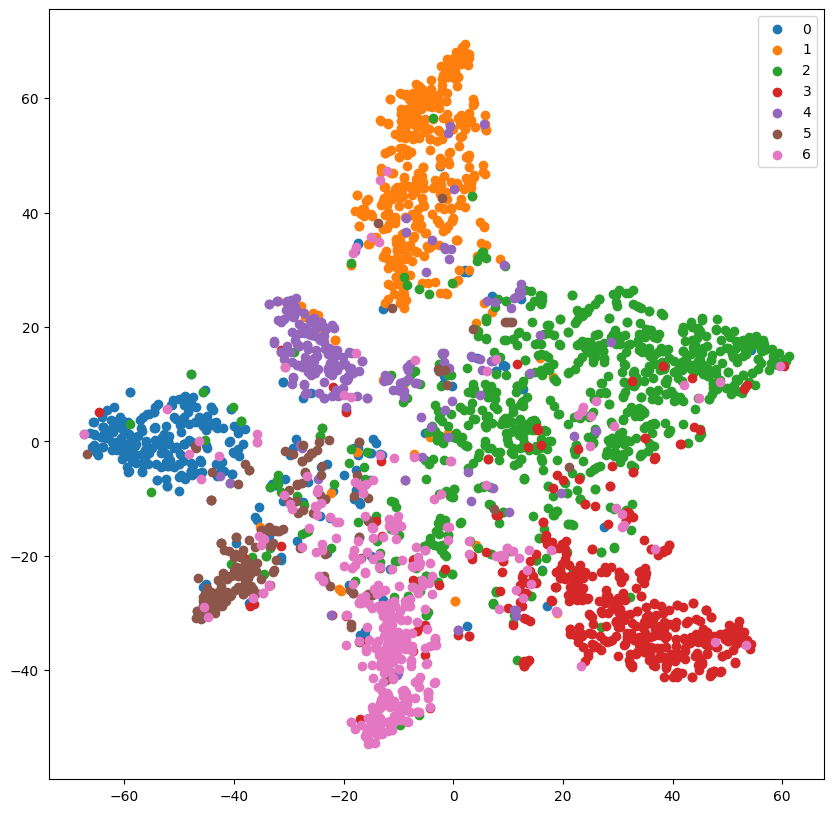

In [ ]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)


x_tsne = TSNE(n_components=2).fit_transform(activations[3])

def plot_tSNE(labels_encoded,x_tsne):
  color_map = np.argmax(labels_encoded, axis=1)
  plt.figure(figsize=(10,10))
  for cl in range(num_classes):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
  plt.legend()
  plt.show()

plot_tSNE(labeled,x_tsne)

In [ ]:
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(labels)

In [ ]:
print((labels_encoded))

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [ ]:
print(len(X))
print(len(y_pred))

2708
2708
